In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
import warnings
warnings.filterwarnings('ignore')

# GLOBAL
nonDataCols = ['patient_id', 'sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)','patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)','patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']

> Read Data

In [2]:
raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Data Obeservation

,patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration (mchc),leukocytes,basophils,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,5041,5041,5042,5045,5042,5042,5042,5042,5042,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,89.316088,89.316088,89.333806,89.38696,89.333806,89.333806,89.333806,89.333806,89.333806,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


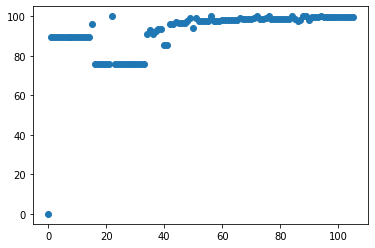

In [3]:
raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

obs = show_missing_features(raw_data)
for x in nonDataCols:
    obs.drop(columns=[x], inplace=True)

[percent] = obs[1:2].values
plt.scatter([i for i in range(0, obs.shape[1])], percent)
obs.head()

> Data Cleaning

In [4]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        raw_data[x].fillna(raw_data[x].mean())

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,451,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3669,8,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5457,5,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4843,15,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


> Feature Engineering

In [5]:
normalized_data = raw_data - raw_data.mean()

for x in nonDataCols:
    normalized_data.drop(columns=[x], inplace=True)

pca_size = 20
pca = PCA(n_components=pca_size)
pca.fit(normalized_data)

dataset = pd.DataFrame(pca.transform(normalized_data),
columns=['feature%s' % _ for _ in range(pca_size)],
index=raw_data.index)

for i, v in enumerate(nonDataCols):
    dataset.insert(i, v, raw_data[v])

dataset.head()

,patient_id,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",feature0,feature1,feature2,feature3,feature4,...,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19
0,1588,0,0,0,0,-459.185996,21.369325,-1.954074,-1.368605,-3.335151,...,0.711491,0.416025,0.283700,0.251134,0.027102,0.095836,0.158376,0.069797,0.087045,0.189940
1,451,0,0,0,0,3825.040571,-963.485107,-354.400607,23.375124,-1162.404300,...,111.234399,4.933126,-38.565040,54.115493,-64.459694,16.992792,-36.168854,-32.168891,-50.127977,11.060050
2,3669,0,0,0,0,-459.188455,21.369152,-1.948759,-1.370712,-3.330891,...,0.714949,0.414959,0.274832,0.253342,0.023134,0.101793,0.145677,0.059162,0.080810,0.199882
3,5457,0,0,0,0,-459.189931,21.369047,-1.945570,-1.371976,-3.328335,...,0.717023,0.414319,0.269511,0.254667,0.020753,0.105367,0.138057,0.052781,0.077069,0.205848
4,4843,0,0,0,0,-459.178808,21.372791,-1.957604,-1.365832,-3.343659,...,0.695108,0.411485,0.285917,0.251452,0.033547,0.088540,0.139204,0.074972,0.081150,0.179241


> Split Train/Test Data (Row 5001 - 5645 as test)

In [6]:
dataCols = [x for x in dataset.columns if x not in nonDataCols]
X = dataset[dataCols]
y = dataset['patient_addmited_to_regular_ward_(1=yes,_0=no)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 5000, shuffle=False)

> Model Training and Evaluating

In [7]:
accuracy_list = []
default_acc_list = []
tuned_acc_list = []

# cv_acc_list = []

# model assessment function
def model_assess(model, name='Default', prob='True'):
    # model.fit(X_train, y_train)
    print('Assess Model:', name)
    prds = model.predict(X_test)
    
    # accuracy
    model_acc = accuracy_score(y_test, prds)
    accuracy_list.append(100*model_acc)
    if name.startswith('Tuned'):
        tuned_acc_list.append(100*model_acc)
    else:
        default_acc_list.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)))
    
    # cross validation
    # cv = cross_val_score(model, X_train, y_train, scoring='accuracy')
    # cv = cv.mean()
    # cv_acc_list.append(100*cv)

    if prob:
        prdProb_y = model.predict_proba(X_test)[:,1]
        print("ROC AUC:", roc_auc_score(y_test, prdProb_y))
    
    print(classification_report(y_test, prds, target_names=['neg', 'pos'])) # TODO
    sns.set()
    mat = confusion_matrix(y_test, prds)
    f, ax = plt.subplots()
    sns.heatmap(mat, annot=True, ax=ax)
    ax.set_title(name + ' Confusion Matrix')
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')

In [8]:
# tune params with kfold
def TuneModelParams(model, name, params):
    print("Tuning", name, '...')
    score = make_scorer(accuracy_score)
    kfold = KFold(n_splits=10)
    grid = GridSearchCV(estimator=model, param_grid=params, scoring=score, cv=kfold)
    grid.fit(X_train, y_train)
    print('best score:', grid.best_score_)
    print('best params:')
    for key in params.keys():
        print(key, '=', grid.best_estimator_.get_params()[key])
    return grid

> Random Forest

Assess Model: Random Forest
Accuracy: 0.9518633540372671
ROC AUC: 0.8929072049341182
              precision    recall  f1-score   support

         neg       0.96      1.00      0.98       615
         pos       0.25      0.03      0.06        29

    accuracy                           0.95       644
   macro avg       0.60      0.51      0.52       644
weighted avg       0.92      0.95      0.93       644

Tuning Random Forest ...
best score: 0.9896
best params:
max_depth = 10
min_samples_split = 2
min_samples_leaf = 2
bootstrap = False
Assess Model: Tuned Random Forest
Accuracy: 0.9518633540372671
ROC AUC: 0.92183908045977
              precision    recall  f1-score   support

         neg       0.96      1.00      0.98       615
         pos       0.25      0.03      0.06        29

    accuracy                           0.95       644
   macro avg       0.60      0.51      0.52       644
weighted avg       0.92      0.95      0.93       644



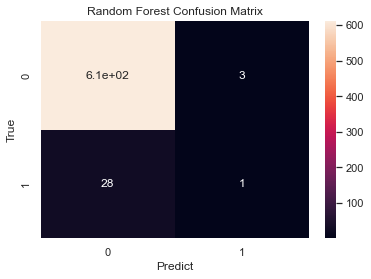

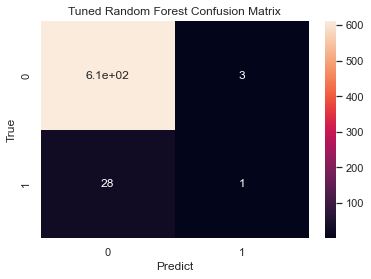

In [9]:
# Random Forest
def RF():
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    return forest

# Random Forest, params tuned by CV
def CV_RF():
    forest = RandomForestClassifier()
    params = {
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }
    return TuneModelParams(forest, 'Random Forest', params)

# Assessment
model_assess(RF(), "Random Forest")
model_assess(CV_RF(), "Tuned Random Forest")

> Linear SVC

Assess Model: SVC
Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

         neg       0.99      0.91      0.95       615
         pos       0.33      0.90      0.48        29

    accuracy                           0.91       644
   macro avg       0.66      0.91      0.72       644
weighted avg       0.96      0.91      0.93       644

Tuning SVC ...
best score: 0.99
best params:
penalty = l1
loss = squared_hinge
dual = False
max_iter = 100
Assess Model: Tuned SVC
Accuracy: 0.9549689440993789
              precision    recall  f1-score   support

         neg       0.95      1.00      0.98       615
         pos       0.00      0.00      0.00        29

    accuracy                           0.95       644
   macro avg       0.48      0.50      0.49       644
weighted avg       0.91      0.95      0.93       644



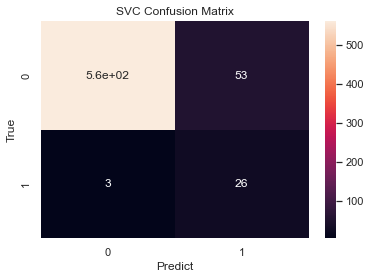

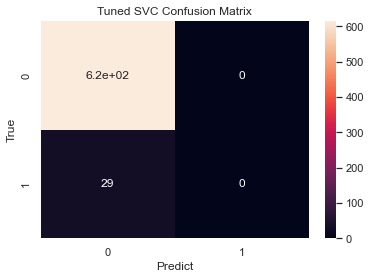

In [10]:
# Linear SVC
def SVC():
    svc = LinearSVC()
    svc.fit(X_train, y_train)
    return svc

# Linear SVC, params tuned by CV
def CV_SVC():
    svc = LinearSVC()
    params = {
        'penalty': ['l1', 'l2'],
        'loss': ['hinge', 'squared_hinge'],
        'dual': [True, False],
        'max_iter': [100, 1000, None]
    }
    return TuneModelParams(svc, 'SVC', params)

# Assessment
model_assess(SVC(), "SVC", False)
model_assess(CV_SVC(), "Tuned SVC", False)

> K Nearest Neighbors

Assess Model: KNN
Accuracy: 0.953416149068323
ROC AUC: 0.6691337258200168
              precision    recall  f1-score   support

         neg       0.95      1.00      0.98       615
         pos       0.00      0.00      0.00        29

    accuracy                           0.95       644
   macro avg       0.48      0.50      0.49       644
weighted avg       0.91      0.95      0.93       644

Tuning KNN ...
best score: 0.99
best params:
n_neighbors = 2
leaf_size = 10
Assess Model: Tuned KNN
Accuracy: 0.953416149068323
ROC AUC: 0.5738716007849735
              precision    recall  f1-score   support

         neg       0.95      1.00      0.98       615
         pos       0.00      0.00      0.00        29

    accuracy                           0.95       644
   macro avg       0.48      0.50      0.49       644
weighted avg       0.91      0.95      0.93       644



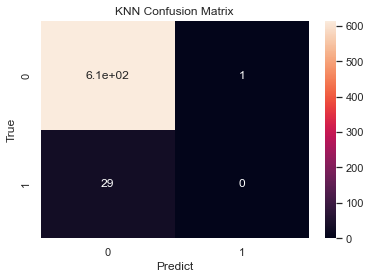

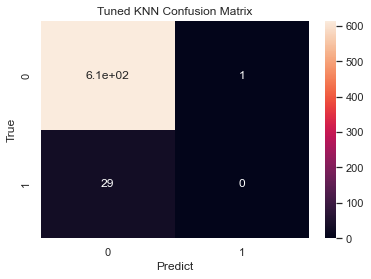

In [11]:
# K nearest neighbors
def KNN():
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    return knn

# K nearest neighbors, params tuned by CV
def CV_KNN():
    knn = KNeighborsClassifier()
    params = {
        'n_neighbors': [2, 5, 10, 50],
        'leaf_size': [10, 30, 100]
    }
    return TuneModelParams(knn, 'KNN', params)

# Assessment
model_assess(KNN(), "KNN")
model_assess(CV_KNN(), "Tuned KNN")

> Comparison

In [12]:
# Demostrate model results on Train split
def acc_compare(model_list, acc_list, xl, yl='% of Accuracy', title='Accuracy of different Classifier Models'):
    ax = sns.barplot(x=model_list, y = acc_list, palette = "coolwarm", saturation =2.0)
    plt.title(title, fontsize = 16)
    plt.xlabel(xl+' Models', fontsize = 12)
    plt.ylabel(yl, fontsize = 12)
    plt.xticks(fontsize = 12, horizontalalignment = 'center')
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
    plt.show
    
default_model_list = ['RF', 'SVC', 'KNN']
tuned_model_list = ['Tuned RF', 'Tuned SVC', 'Tuned KNN']
all_model_list = ['RF', 'Tuned RF', 'SVC', 'Tuned SVC', 'KNN','Tuned KNN']

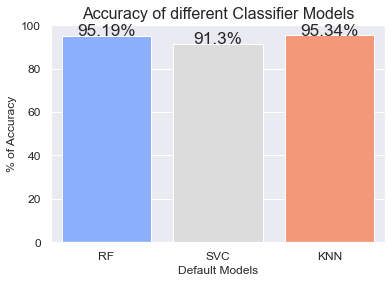

In [13]:
# Default models comparison
acc_compare(model_list=default_model_list, acc_list=default_acc_list ,xl='Default')

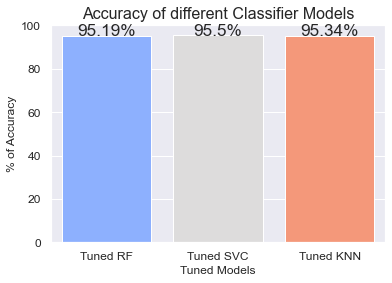

In [14]:
# Tuned models comparison
acc_compare(model_list=tuned_model_list, acc_list=tuned_acc_list, xl='Tuned')

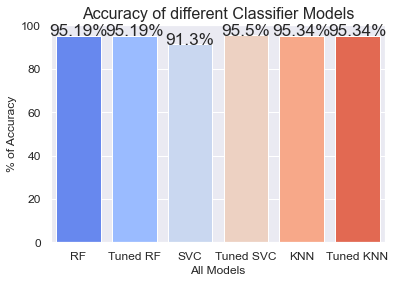

In [15]:
# All models comparison
acc_compare(model_list=all_model_list, acc_list=accuracy_list, xl='All')